In [1]:
%run common_init.py

Start import
Host: DESKTOP-URE1BBI.localdomain
Setting tmp folder to /tmp/
calculating effective efficiency for Xe detector done
calculating effective efficiency for Ge detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Xe_migd detector done
calculating effective efficiency for Ge_migd detector done
calculating effective efficiency for Ar_migd detector done
Done import
SYSTEM
	Running on linux
	Python version 3.7.6 (default, Jan  8 2020, 19:59:22) [GCC 7.3.0]
	Python installation /home/joran/miniconda3/envs/dddm/bin/python
MODULES
	DirectDmTargets
		ver.:	0.2.0
		Path:	/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/

	wimprates
		ver.:	0.3.2
		Path:	/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/



In [131]:
save_dir = '/home/joran/google_drive/200202_results_dddm'

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

02 Jan. 2020


## HALO model ##
In DirectDmTargets (dddm) we have two ways of generating spectra:
 - Directly from wimprates. See: <https://github.com/jorana/wimprates> (cloned from  <https://github.com/JelleAalbers/wimprates>) 
 - Loading velocity distributions from verne into wimprates to generate a spectrum of dark matter by integrating the velocity distribution with wimprates <https://github.com/jorana/verne> (cloned from <https://github.com/bradkav/verne>)


In [2]:
plt.rcParams['axes.grid'] = True

In [96]:
def n_int_f(f,v):
    '''numerically calculate the integral of f*v*dv'''
    bin_widths = v[1:]-v[:-1]
    av_bin_width = np.mean(bin_widths)
    assert np.all(abs(bin_widths-av_bin_width) -1 < 0.01), "use equal bin-spacing"
    return np.sum(f * v * bin_widths[0])

/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/halo.py:144: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


Num. int. of SHM=	1.0
Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.300/sig_-35.0_mx_0.00_avg.csv for the velocity distribution
Num. int. of -35=	1.0084209965671804
Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.300/sig_-34.0_mx_0.00_avg.csv for the velocity distribution
Num. int. of -34=	0.7775561111554895
Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.300/sig_-33.0_mx_0.00_avg.csv for the velocity distribution
Num. int. of -33=	0.5541016709504856
Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.300/sig_-32.0_mx_0.00_avg.csv for the velocity distribution
Num. int. of -32=	0.5026991345922605
Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.300/sig_-31.0_mx_0.00_avg.csv for the velocity distribution
Num. int. of -31=	0.3884933827051641
Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.3

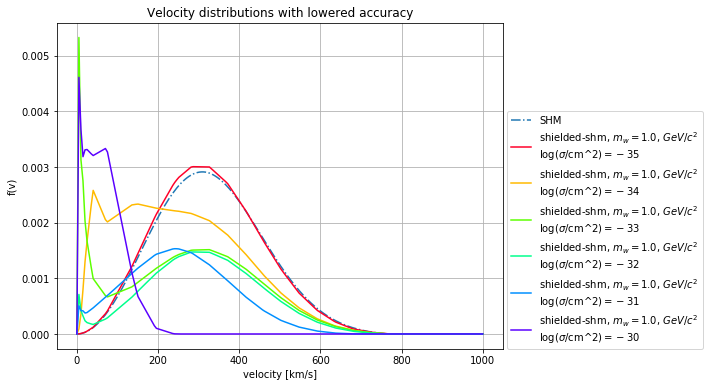

In [210]:
# Plot -options
plt.figure(figsize = (8,6))
nplots = 7
cm = plt.get_cmap('gist_rainbow')

# velocity
vel = np.linspace(0,1000,200)

# load standard-halo-model spectrum with given parameters
args = dict(v_0=230* nu.km / nu.s, v_esc = 544* nu.km / nu.s, rho_dm = 0.3 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
shm_dist = dddm.SHM(**args)
f = shm_dist.velocity_dist(vel*nu.km/nu.s, 0) * nu.km/nu.s
plt.plot(vel, f, label = 'SHM', linestyle = '-.')
int_shm = n_int_f(f,vel)
print(f'Num. int. of {"SHM"}=\t{int_shm/int_shm}')

# Make the mass and the location explicit
log_mw = 0
loc = "XENON"
s_min, s_max, d_s = -35, -29, 1 # plot: from - to - with steps
nplots = nplots = (s_max - s_min)  // d_s
# loop over cross-sections
for i, sig in enumerate(np.arange(s_min, s_max, d_s)):
    args['log_cross_section'] = sig
    args['log_mass'] = log_mw
    args['location'] = loc
    verne_dist = dddm.VerneSHM(**args)
    f = verne_dist.velocity_dist(vel*nu.km/nu.s, 0)*nu.km/nu.s
    plt.plot(vel, f, 
             c = cm(float(i)/nplots),
             label = f'shielded-shm, $m_w=%.1f$, $GeV/c^2$\n$\log(\sigma/$cm^2$) = {sig}$'%(10**log_mw))
    print(f'Num. int. of {sig}=\t{n_int_f(f,vel)/int_shm}')
plt.legend(loc=(1.01,0))
plt.xlabel('velocity [km/s]')
plt.ylabel('f(v)')
plt.title('Velocity distributions with lowered accuracy')
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/quick_verne.{f_type}', dpi = 100, bbox_inches= 'tight')

# Load the full verne simulation
below we load the full verne simulation with the default options, this takes somewhat longer than the procedure as on the forked verne code as linked above.

In [ ]:
# Command to load
save = "/mnt/c/Users/Joran/dddm_data/verne/full_spec.csv" 
!python "/home/joran/google_drive/windows-anaconda/verne/"/src/CalcVelDist_full.py -m_x 1 -sigma_p 1e-34 -loc XENON -path "/home/joran/google_drive/windows-anaconda/verne//src/" -v_0 229.99999999999997 -v_esc 544.0 -save_as $save

In [132]:
# A copy of the full spectrum has been saved at:
df = pd.read_csv('/home/joran/google_drive/windows-anaconda/verne/results/full_veldists/f_all_XENON_229_544_-78.3_1.00.csv')

# The df contains several values of the angle gamma, disentangle those here:
_,x,y  = df.keys()
headers = np.unique(df['gamma/pi'].values)
def get_average(df, headers, projection):
    masks = np.array([df['gamma/pi'] == header for header in headers])
    combined = np.array([df[mask][projection].values for mask in masks])
    return np.average(combined,axis = 0)
df_average = pd.DataFrame()
for projection in [x,y]:
    df_average[projection] = get_average(df, headers, projection)

# The different angles
headers = np.unique(df['gamma/pi'].values)
n_headers = len(headers)

### plot verne
below we plot the full verne calculation and compare it with the calculation as performed by the forked github branch as linked above

/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/forked_wimprates/wimprates/halo.py:144: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.300/sig_-34.0_mx_0.00_avg.csv for the velocity distribution
Num. int. at average (quick)=	0.7775561111554895
Num. int. at average (full) =	0.7641250701979605
Quick method is off by -1.8%


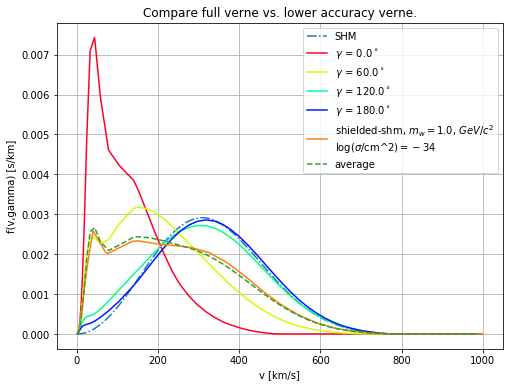

In [204]:
# Plot options
plt.figure(figsize = (8,6))
plt.xlabel("v [km/s]")

# Plot shm
plt.plot(vel, shm_dist.velocity_dist(vel*nu.km/nu.s, 0) * nu.km /nu.s, label = 'SHM', linestyle = '-.')
plt.ylim()*2

# Plot for the angles
for i, header in enumerate(headers):
    mask = df['gamma/pi'] == header
    kwargs = {'color': cm(float(i)/n_headers),
        'label': '$\gamma$ = %.1f$^\circ$'%np.rad2deg(header*np.pi)}
    plt.plot(df[mask][x], df[mask][y], **kwargs)    
    plt.ylabel(y.replace("_"," "))
    
# Again plot the corresponding distribution as done above
sig = -34
args['log_cross_section'] = sig
verne_dist = dddm.VerneSHM(**args)
f_quick = verne_dist.velocity_dist(vel*nu.km/nu.s, 0) * nu.km /nu.s
plt.plot(vel, f_quick, 
     label = f'shielded-shm, $m_w=%.1f$, $GeV/c^2$\n$\log(\sigma/$cm^2$) = {sig}$'%(10**log_mw))
quick_ratio = n_int_f(f_quick, vel)/int_shm
print(f'Num. int. at average (quick)=\t{quick_ratio}')

# Also plot the average of the full simulation
plt.plot(df_average[x],df_average[y], label = 'average', linestyle = '--')
def f_in(x0,y0, x):
        return scipy.interpolate.interp1d(x0,y0, bounds_error=False, fill_value=0)(x)
full_ratio = n_int_f(f_in(df_average[x], df_average[y], vel), vel)/int_shm
print(f'Num. int. at average (full) =\t{full_ratio}')
plt.legend()
plt.title('Compare full verne vs. lower accuracy verne.')


print(f'Quick method is off by %.1f'%(100 * (1-quick_ratio / full_ratio)) + '%')
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/compare_verne.{f_type}', dpi = 100, bbox_inches= 'tight')
    


In [270]:
# No detector resolution
def plot_spectrum(data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    plt.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                markersize =3,
                label = label
                )
def plot_spectrum_ax(ax, data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    print(np.sum(data['counts']))
    ax.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                markersize =3,
                label = label
                )
def get_gal_spec(det, mw = 1, sigma = 1e-34, nbins = 10):
    events = dddm.GenSpectrum(mw, sigma, use_SHM, dddm.experiment[det])
    events.n_bins = nbins
    return events.get_data(poisson = False)

In [271]:
def get_det_spec(det, mw = 1, sigma = 1e-34, nbins = 10, background = True,):
    events = dddm.DetectorSpectrum(mw, sigma, use_SHM, dddm.experiment[det])
    events.n_bins = nbins
    events.add_background = background
    return events.get_data(poisson = False)

In [279]:
def plot_spectra(det, mw = 1, sigma = 1e-34, nbins = 10):
    fig, (ax1,ax2) = plt.subplots(2, figsize = (14,8), sharex = True)
    
    gal_spec = get_gal_spec(det, mw = mw, sigma = sigma, nbins = nbins)
    bg_spec = get_det_spec(det, mw = mw, sigma = sigma, nbins = nbins, background = False)
    
    ax1.set_title('spectrum log. scale')
    plot_spectrum_ax(ax1, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters (gal_spec)')
    
    plot_spectrum_ax(ax1,bg_spec,color =  'black', 
                     label = f'{det} (bg_spec)')

    ax1.set_ylim(bottom=np.max([plt.ylim()[-1], (1e-10 * 10/nbins)]))
    ax1.set_yscale("log")
    
    ax2.set_title('spectrum lin. scale')
    plot_spectrum_ax(ax2, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters')
    plot_spectrum_ax(ax2,bg_spec,color =  'black', 
                     label = f'{det}')
    ax2.set_ylim(0, 2 * bg_spec['counts'].max())
    for ax in [ax1,ax2]:
        ax.axvline(dddm.experiment[det]['E_thr'], label = 'energy threshold')
        ax.grid(axis="both")
        ax.set_ylabel('counts/keV')
        ax.legend()
    plt.xlabel('E [keV]')

In [280]:
args = dict(v_0=230* nu.km / nu.s, v_esc = 544* nu.km / nu.s, rho_dm = 0.3 * nu.GeV / nu.c0 ** 2 / nu.cm ** 3)
use_SHM = dddm.SHM(**args)

929167803.2407032
1037133.3184347316
929167803.2407032
1037133.3184347316
CPU times: user 23min 39s, sys: 4.17 s, total: 23min 43s
Wall time: 23min 42s


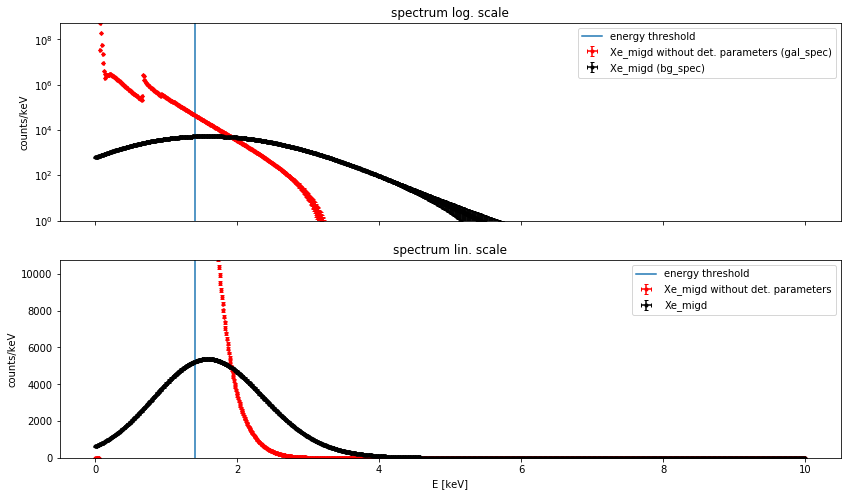

In [283]:
%%time
plot_spectra('Xe_migd', nbins = 1000)
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/shm_det.spectrum1.{f_type}', dpi = 100, bbox_inches= 'tight')

In [286]:
log_mw = 0
loc = "XENON"
sig = -34
args['log_cross_section'] = sig
args['log_mass'] = log_mw
args['location'] = loc
use_SHM = dddm.VerneSHM(**args)


Using /mnt/c/Users/Joran/dddm_data/verne/f_params/loc_XENON/v0_229/vesc_544/rho_0.300/sig_-34.0_mx_0.00_avg.csv for the velocity distribution


----
finding negative rates. Doing hard override!!
----




----
finding negative rates. Doing hard override!!
----


570449224.6709875
551099.8634949675
570449224.6709875
551099.8634949675
CPU times: user 1h 2min 48s, sys: 9.12 s, total: 1h 2min 57s
Wall time: 1h 2min 52s


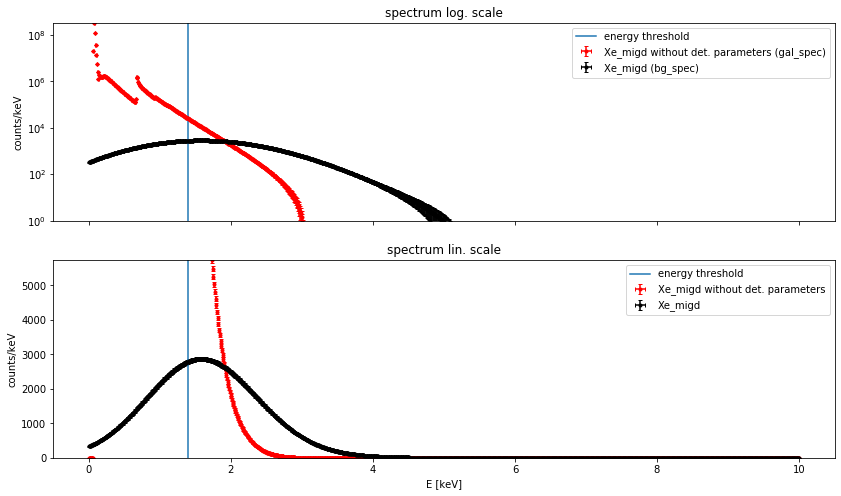

In [287]:
%%time
plot_spectra('Xe_migd', nbins = 1000)
for f_type in ['pdf', 'png']:
    plt.savefig(f'{save_dir}/verne_det.spectrum2.{f_type}', dpi = 100, bbox_inches= 'tight')

In [289]:
use_SHM.rho_dm_nodim

0.3